In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)
np.random.seed(0)

# Set device to MPS if available (Apple Silicon), else CPU
if not torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device (Apple Silicon GPU) 🚀")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device 🚀")
else:
    device = torch.device("cpu")
    print("Using CPU device")

print("Imports OK ✅")

Using CPU device
Imports OK ✅


In [51]:
df = pd.read_csv('//Users/gasper/Documents/PSL/year_1/semster_1/un-supervised-learning/homework/big5/tests.tsv', sep='\t')
print('Number of participants: ', len(df))
df.head()

Number of participants:  19719


,age,gender,country,E1,E2,E3,N1,N2,N3,A1,A2,A3,C1,C2,C3,O1,O2,O3
0,53,1,US,4.0,5.0,5.0,1.0,2.0,1.0,5.0,5.0,5.0,4.0,5.0,4.0,3.0,4.0,5.0
1,46,2,US,2.0,3.0,3.0,2.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,3.0,3.0,2.0
2,14,2,PK,5.0,1.0,5.0,5.0,5.0,5.0,1.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0
3,19,2,RO,2.0,2.0,3.0,5.0,4.0,5.0,5.0,4.0,3.0,3.0,4.0,2.0,5.0,5.0,5.0
4,25,2,US,3.0,3.0,3.0,3.0,3.0,3.0,5.0,5.0,5.0,3.0,5.0,3.0,1.0,3.0,3.0


In [52]:
dropped_df = df.drop(["age", "country"], axis=1)
dropped_df.head()

,gender,E1,E2,E3,N1,N2,N3,A1,A2,A3,C1,C2,C3,O1,O2,O3
0,1,4.0,5.0,5.0,1.0,2.0,1.0,5.0,5.0,5.0,4.0,5.0,4.0,3.0,4.0,5.0
1,2,2.0,3.0,3.0,2.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,3.0,3.0,2.0
2,2,5.0,1.0,5.0,5.0,5.0,5.0,1.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0
3,2,2.0,2.0,3.0,5.0,4.0,5.0,5.0,4.0,3.0,3.0,4.0,2.0,5.0,5.0,5.0
4,2,3.0,3.0,3.0,3.0,3.0,3.0,5.0,5.0,5.0,3.0,5.0,3.0,1.0,3.0,3.0


gender is the y and everyting else are the input variables



In [53]:
# Remove rows with missing values
df_clean = dropped_df.dropna()
print(f'Number of participants after removing missing values: {len(df_clean)}')

# Separate features (X) and target (y)
# gender is the target variable (y), everything else are features (X)
X = df_clean.drop('gender', axis=1).values  # All personality trait columns
y = df_clean['gender'].values  # Gender column

# Filter to binary classification: Male (1) vs Female (2)
# Remove "Other" (3) and "Unanswered" (0) for simpler binary classification
mask = (y == 1) | (y == 2)
X = X[mask]
y = y[mask]

# Convert to binary: Male=0, Female=1
y = (y == 2).astype(int)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'Class distribution: {np.bincount(y)} (Male: {np.bincount(y)[0]}, Female: {np.bincount(y)[1]})')
print(f'Female proportion: {y.mean():.3f}')


Number of participants after removing missing values: 19718
X shape: (19592, 15)
y shape: (19592,)
Class distribution: [ 7608 11984] (Male: 7608, Female: 11984)
Female proportion: 0.612


In [54]:
# Step 1: Split into train (60%) and temp (40%)
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

# Step 2: Split temp into val (20% total) and test (20% total)
X_va, X_te, y_va, y_te = train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.5,
    random_state=43,
    stratify=y_tmp
)

print(f'\nTrain set: {X_tr.shape}')
print(f'Val set:   {X_va.shape}')
print(f'Test set:  {X_te.shape}')

# Convert to PyTorch tensors and move to device (MPS/CUDA/CPU)
X_train_t = torch.tensor(X_tr, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_va, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_te, dtype=torch.float32).to(device)

y_train_t = torch.tensor(y_tr, dtype=torch.long).to(device)
y_val_t = torch.tensor(y_va, dtype=torch.long).to(device)
y_test_t = torch.tensor(y_te, dtype=torch.long).to(device)

print(f'\nTensors created:')
print(f'X_train_t: {X_train_t.shape}, y_train_t: {y_train_t.shape}')
print(f'X_val_t: {X_val_t.shape}, y_val_t: {y_val_t.shape}')
print(f'X_test_t: {X_test_t.shape}, y_test_t: {y_test_t.shape}')
print(f'Tensors on device: {X_train_t.device}')


Train set: (11755, 15)
Val set:   (3918, 15)
Test set:  (3919, 15)

Tensors created:
X_train_t: torch.Size([11755, 15]), y_train_t: torch.Size([11755])
X_val_t: torch.Size([3918, 15]), y_val_t: torch.Size([3918])
X_test_t: torch.Size([3919, 15]), y_test_t: torch.Size([3919])
Tensors on device: cpu


In [55]:
model = nn.Sequential(
    nn.Linear(15, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 2)
).to(device)  # Move model to device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)
print(f'Model on device: {next(model.parameters()).device}')

Sequential(
  (0): Linear(in_features=15, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Model on device: cpu


In [56]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

12450


In [57]:
def accuracy(model, X_t, Y_t):
    with torch.no_grad():
        logits = model(X_t)           # [N,2]
        preds = torch.argmax(logits, dim=1)
        correct = (preds == Y_t).float().mean().item()
    return correct


In [58]:
best_val_acc = 0.0
best_weights = None

batch_size = 64
epochs = 100

train_loss_history = []
val_acc_history = []

N = X_train_t.shape[0]

for epoch in range(epochs):
    model.train()
    perm = torch.randperm(N)
    total_loss = 0.0

    for start in range(0, N, batch_size):
        idx = perm[start:start+batch_size]
        xb = X_train_t[idx]
        yb = y_train_t[idx]

        # forward
        logits = model(xb)            # [batch,2]
        loss = loss_fn(logits, yb)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / N
    train_loss_history.append(avg_loss)

    # validation accuracy
    model.eval()
    val_acc = accuracy(model, X_val_t, y_val_t)
    val_acc_history.append(val_acc)

    # save best model so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = {k: v.detach().clone() for k,v in model.state_dict().items()}

    print(f"Epoch {epoch+1:02d}/{epochs}  loss={avg_loss:.4f}  val_acc={val_acc:.4f}")

print("Best validation accuracy:", best_val_acc)

# restore best weights
if best_weights is not None:
    model.load_state_dict(best_weights)


Epoch 01/100  loss=0.6378  val_acc=0.6524
Epoch 02/100  loss=0.6286  val_acc=0.6468
Epoch 03/100  loss=0.6269  val_acc=0.6557
Epoch 04/100  loss=0.6228  val_acc=0.6554
Epoch 05/100  loss=0.6239  val_acc=0.6365
Epoch 06/100  loss=0.6225  val_acc=0.6554
Epoch 07/100  loss=0.6201  val_acc=0.6565
Epoch 08/100  loss=0.6188  val_acc=0.6544
Epoch 09/100  loss=0.6188  val_acc=0.6526
Epoch 10/100  loss=0.6172  val_acc=0.6516
Epoch 11/100  loss=0.6172  val_acc=0.6554
Epoch 12/100  loss=0.6138  val_acc=0.6519
Epoch 13/100  loss=0.6137  val_acc=0.6470
Epoch 14/100  loss=0.6113  val_acc=0.6514
Epoch 15/100  loss=0.6115  val_acc=0.6498
Epoch 16/100  loss=0.6099  val_acc=0.6470
Epoch 17/100  loss=0.6074  val_acc=0.6521
Epoch 18/100  loss=0.6066  val_acc=0.6340
Epoch 19/100  loss=0.6041  val_acc=0.6480
Epoch 20/100  loss=0.6036  val_acc=0.6429
Epoch 21/100  loss=0.6018  val_acc=0.6485
Epoch 22/100  loss=0.6016  val_acc=0.6498
Epoch 23/100  loss=0.6002  val_acc=0.6432
Epoch 24/100  loss=0.5978  val_acc

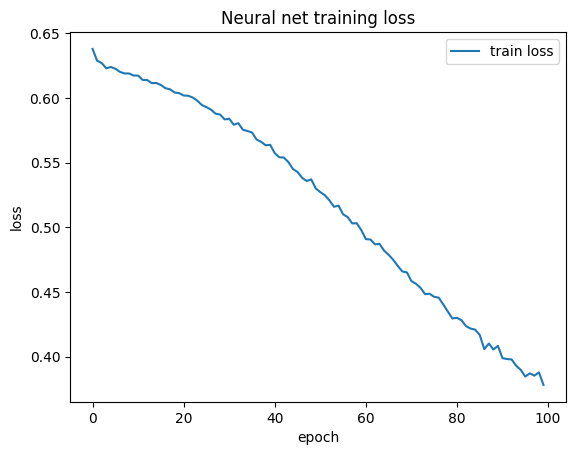

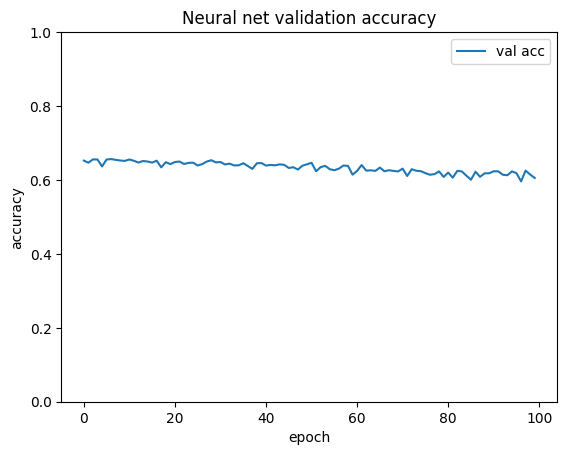

In [59]:
plt.figure()
plt.plot(train_loss_history, label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Neural net training loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_acc_history, label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.title("Neural net validation accuracy")
plt.legend()
plt.show()

In [60]:
model.eval()
test_acc_nn = accuracy(model, X_test_t, y_test_t)
print(f"Neural Net accuracy (test): {test_acc_nn:.3f}")

# Confusion matrix for the neural net
with torch.no_grad():
    logits_test = model(X_test_t)
    preds_test = torch.argmax(logits_test, dim=1).numpy()




Neural Net accuracy (test): 0.654
